# 타이타닉 생존 여부 예측하기

## 1. 데이터 확인

### 라이브러리 불러오기

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'  #선명하게 만들기

import warnings
warnings.filterwarnings("ignore")

#맥북 한글
from matplotlib import rc
rc('font', family ='AppleGothic')

pd.set_option('display.max_columns', None) # 모든 열 출력

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,classification_report
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder


### 데이터 불러오기

In [39]:
train = pd.read_csv('../과제 데이터/Titanic-Dataset.csv')
test = pd.read_csv('../과제 데이터/Titanic_test.csv').drop(['Survived'], axis =1)

<Axes: xlabel='Survived', ylabel='count'>

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

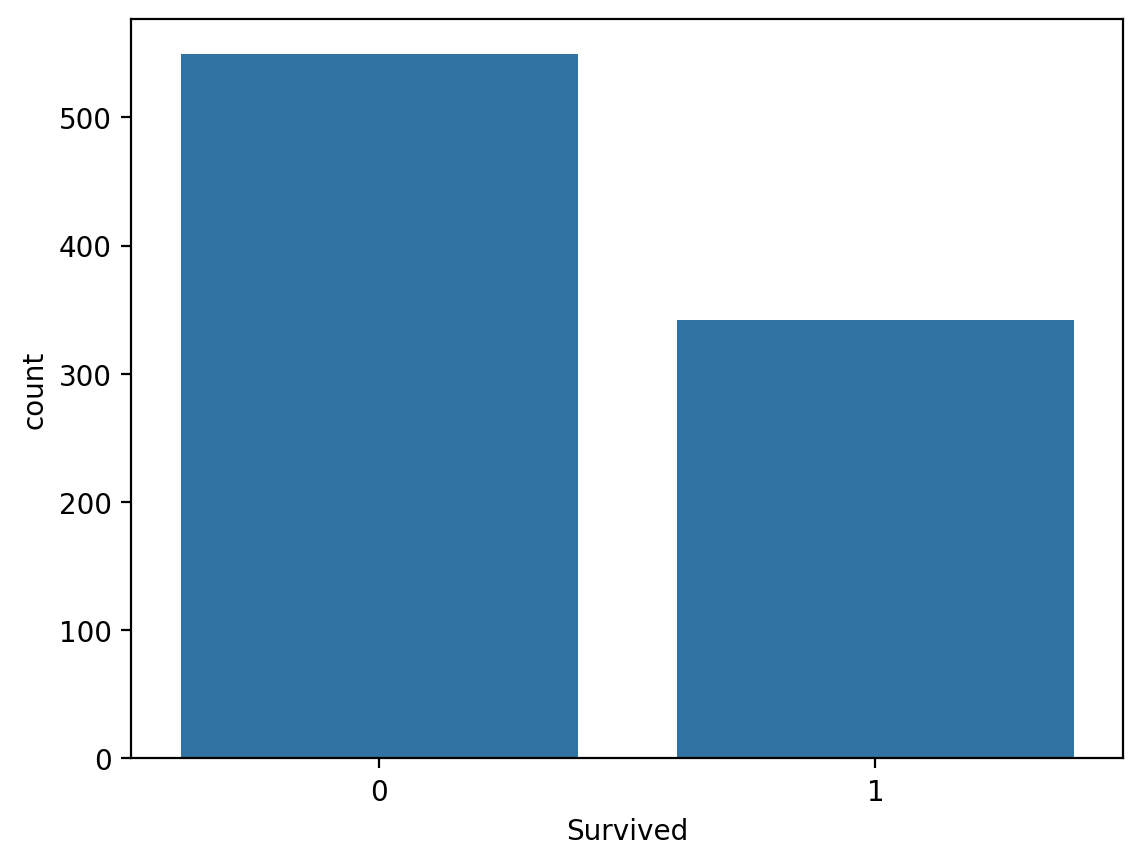

In [98]:
sns.countplot(x='Survived', data=train) ## 타겟변수의 불균형이 보임

In [41]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [42]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [43]:
print(train.shape, test.shape)

(891, 12) (418, 11)


## 2. 데이터 1차 전처리 수행
**전처리 근거는 3주차 모델링 1에서 Titanic_pt.1_Preprocessing.ipynb 참고 !**
- 전처리는 train, test 데이터 각각 같은 전처리를 수행해주어야 한다.
- 이때 data leakage가 일어나지 않도록 유의하여 전처리 수행

### 2.1 파생변수 생성

In [44]:
#Name에서 Surname, Title, Firstname을 분리해주는 함수 생성
def Name_split(name):
    
    Surname, Title, Firstname = name.split(",")[0], name.split(",")[1].split(".")[0][1:], name.split(",")[1].split(".")[1][1:]
    return Surname, Title, Firstname

In [45]:
#Name_split 함수 적용 후, 리스트에 저장
Surname_list = []
Title_list = []
Firstname_list = []

for i in range(len(train)):
    Surname_list.append(Name_split(train["Name"][i])[0])
    Title_list.append(Name_split(train["Name"][i])[1])
    Firstname_list.append(Name_split(train["Name"][i])[2])

train['Surname'] = Surname_list
train['Title'] = Title_list
train['Firstname'] = Firstname_list

In [46]:
#Name_split 함수 적용 후, 리스트에 저장
Surname_list = []
Title_list = []
Firstname_list = []

for i in range(len(test)):
    Surname_list.append(Name_split(test["Name"][i])[0])
    Title_list.append(Name_split(test["Name"][i])[1])
    Firstname_list.append(Name_split(test["Name"][i])[2])

test['Surname'] = Surname_list
test['Title'] = Title_list
test['Firstname'] = Firstname_list

In [47]:
#Title 호칭 재분류
train["Title"].replace(["Capt","Col","Dr","Jonkheer","Major","Rev","Sir","the Countess"], "Others", inplace=True)
train["Title"].replace(["Mlle","Ms"], "Miss", inplace=True)
train["Title"].replace(["Mme","Lady","Dona"], "Mrs", inplace=True)
train["Title"].replace("Don", "Mr", inplace=True)

In [48]:
#Title 호칭 재분류
test["Title"].replace(["Capt","Col","Dr","Jonkheer","Major","Rev","Sir","the Countess"], "Others", inplace=True)
test["Title"].replace(["Mlle","Ms"], "Miss", inplace=True)
test["Title"].replace(["Mme","Lady","Dona"], "Mrs", inplace=True)
test["Title"].replace("Don", "Mr", inplace=True)

In [49]:
#SibSp와 Parch 열을 합쳐서 FamilySize라는 새로운 열 생성
train["FamilySize"] = train["SibSp"] + train["Parch"]

test["FamilySize"] = test["SibSp"] + test["Parch"]

### 2.2 결측치 처리

#### Age

In [50]:
#Age의 결측값을 Title별 평균 나이로 대체
train["Age"].fillna(train.groupby("Title")["Age"].transform("mean"), inplace=True)
test["Age"].fillna(test.groupby("Title")["Age"].transform("mean"), inplace=True)

#### Embarked

In [51]:
train.loc[(train['Surname']=='Icard')&(train['Firstname']=='Amelie'), 'Embarked']="C"
train.loc[train['Surname']=='Stone', 'Embarked']="S"

test.loc[(test['Surname']=='Icard')&(test['Firstname']=='Amelie'), 'Embarked']="C"
test.loc[test['Surname']=='Stone', 'Embarked']="S"

#### Cabin

In [52]:
train.drop(['Cabin'], axis =1 , inplace = True)
test.drop(['Cabin'], axis =1 , inplace = True)

#### 나머지 결측치

In [53]:
train.fillna(0, inplace = True)
test.fillna(0, inplace = True)

## 3. 데이터 2차 전처리 수행
- 모델링을 위한 전처리라고 이해
- 마찬가지로 train, test 각각 전처리 수행

### 3.1 명목형 변수 Title, Sex, Embarked : 원핫인코딩
- drop_first = True -> 다중공선성 방지

In [54]:
train = pd.get_dummies(data = train, columns = ['Title', 'Sex', 'Embarked'], drop_first = True) 
test = pd.get_dummies(data = test, columns = ['Title', 'Sex', 'Embarked'], drop_first = True)

### 3.2 순서형 변수 Pclass : 라벨인코딩

In [55]:
train["Pclass"] = train["Pclass"].map({1:2, 2:1, 3:0})
test["Pclass"] = test["Pclass"].map({1:2, 2:1, 3:0})

### 3.3 최종 변수

In [56]:
#필요없는 열은 제거
train.drop(["PassengerId","Name","Surname","Firstname","SibSp",
                           "Parch","Ticket"], axis=1, inplace = True)

test.drop(["PassengerId","Name","Surname","Firstname","SibSp",
                           "Parch","Ticket"], axis=1, inplace = True)

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Age           891 non-null    float64
 3   Fare          891 non-null    float64
 4   FamilySize    891 non-null    int64  
 5   Title_Miss    891 non-null    bool   
 6   Title_Mr      891 non-null    bool   
 7   Title_Mrs     891 non-null    bool   
 8   Title_Others  891 non-null    bool   
 9   Sex_male      891 non-null    bool   
 10  Embarked_Q    891 non-null    bool   
 11  Embarked_S    891 non-null    bool   
dtypes: bool(7), float64(2), int64(3)
memory usage: 41.0 KB


In [58]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        418 non-null    int64  
 1   Age           418 non-null    float64
 2   Fare          418 non-null    float64
 3   FamilySize    418 non-null    int64  
 4   Title_Miss    418 non-null    bool   
 5   Title_Mr      418 non-null    bool   
 6   Title_Mrs     418 non-null    bool   
 7   Title_Others  418 non-null    bool   
 8   Sex_male      418 non-null    bool   
 9   Embarked_Q    418 non-null    bool   
 10  Embarked_S    418 non-null    bool   
dtypes: bool(7), float64(2), int64(2)
memory usage: 16.0 KB


### 3.4 Train/Valid 분리

In [59]:
X_train = train.drop(['Survived'], axis = 1).copy()
y_train = train['Survived'].copy()


x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, #valid dataset의 비율 20프로
                                                      shuffle=True, random_state = 0)

In [60]:
x_test = test.copy()

In [61]:
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_valid = ss.transform(x_valid)
x_test = ss.transform(x_test)

## 4. 모델 학습

- 트리 기반 모델들은 스케일링을 굳이 할 필요가 없음
- 하지만 모델 학습 속도나, 다른 모델에서의 일관성 유지 등으로 쓰는 것을 권장

### 4.1 Decision Tree
- 주어진 입력값들의 조합에 대한 의사결정규칙(rule)에 따라 출력값 예측
- 해석이 수월하다는 장점

#### (1) 모델 선언

In [62]:
model1 = DecisionTreeClassifier(# max_depth = 5,
                        random_state = 42)

#### (2) 하이퍼파라미터 확인 방법

In [63]:
print(model1.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


#### (3) 모델 학습

In [64]:
model1.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

#### (4) 모델 평가

In [65]:
def model_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])
    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))
    print(classification_report(y_test, y_pred, labels=[True, False]))

In [66]:
pred = model1.predict(x_valid)
model_eval(y_valid, pred)

오차행렬:
 [[47 22]
 [16 94]]

정확도: 0.7877
정밀도: 0.7460
재현율: 0.6812
F1: 0.7121
              precision    recall  f1-score   support

        True       0.75      0.68      0.71        69
       False       0.81      0.85      0.83       110

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



### 4.2 랜덤포레스트
- 일반화 및 성능이 우수
- 파라미터 조정이 쉬움
- 과적합이 잘 되지 않음
- 훈련 시 메모리 소모가 큼
- 개별 트리 분석이 어렵고 트리 분리가 복잡해지는 경향 존재

#### 모델 선언

In [67]:
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier(random_state=42)

In [68]:
print(model2.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


#### (1) 모델 학습

In [69]:
model2.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

#### (2) 모델 평가

In [70]:
pred = model2.predict(x_valid)
model_eval(y_valid, pred)

오차행렬:
 [[ 50  19]
 [  9 101]]

정확도: 0.8436
정밀도: 0.8475
재현율: 0.7246
F1: 0.7812
              precision    recall  f1-score   support

        True       0.85      0.72      0.78        69
       False       0.84      0.92      0.88       110

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



### 4.3 XGBoost
- 높은 예측 성능을 보이며 과적합 방지를 위한 다양한 하이퍼파라미터 제공
- 빠른 속도로 대용량 데이터 세트 처리 가능
- 다양한 하이퍼파라미터를 조절할 수 있지만 최적의 조합을 찾기 어려움
- 많은 메모리 소모

#### (1) 모델 선언

In [71]:
!pip install xgboost


In [72]:
from xgboost import XGBClassifier

model3 = XGBClassifier(#n_estimators=200, learning_rate=0.1,subsample=0.8, colsample_bytree=1, max_depth=8 
                       random_state=42)

#### (2) 모델 학습

In [73]:
model3.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

#### (3) 모델 평가

In [74]:
pred = model3.predict(x_valid)
model_eval(y_valid, pred)

오차행렬:
 [[53 16]
 [11 99]]

정확도: 0.8492
정밀도: 0.8281
재현율: 0.7681
F1: 0.7970
              precision    recall  f1-score   support

        True       0.83      0.77      0.80        69
       False       0.86      0.90      0.88       110

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



- 랜덤포레스트 모델이 accuracy = 0.8436, f1-score = 0.7812로 우수한 성능을 보였다.

**랜덤포레스트 모델로 성능 개선을 이루어보자 !**

## 5. 하이퍼파라미터 튜닝

### RandomForestClassifier 하이퍼파라미터
- n_estimator : 생성할 트리의 개수
- max_features : 노드를 분할할 때 고려할 특성의 무작위 하위 집합의 크기
- max_depth : 트리의 최대 깊이
- min_samples_split : 노드를 분할하기 위해 필요한 최소한의 샘플 개수
- min_samples_leaf : 노드를 분할하기 위해 leaf 노드가 가져야할 최소한의 샘플
- max_leaf_nodes : 생성될 수 있는 최대 리프 노드의 개수를 제한
- random_state : 랜덤 시드 지정

### 5.1 GridSearch

In [75]:
# 하이퍼파라미터를 딕셔너리로 설정
model= RandomForestClassifier(random_state = 42)

params_grid = {
    'n_estimators' : [100, 200, 300],
    'max_features' : ['sqrt','log2'],
    'max_depth' : [3, 5, 7],
    'min_samples_split' : [2, 5, 10]
}

GridSearchCV()에서 cv는 cross validation 수

In [76]:
# param_grid 하이퍼 파라미터를 3개의 train, valid set fold 로 나누어 테스트 수행

gs = GridSearchCV(estimator=model,param_grid=params_grid , cv = 3)

# params_grid 의 하이퍼 파라미터를 순차적으로 학습/평가
gs.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [77]:
gs.best_score_

0.8300830880875557

In [78]:
gs.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 300}

#### GridSearch 결과를 데이터 프레임으로 저장하기 
- 어떤 경우에 높은 성능이 나오는지 확인 가능

In [79]:
gs_result = pd.DataFrame(gs.cv_results_)
gs_result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
20,0.389647,0.008737,0.013676,0.002945,5,sqrt,2,300,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.810924,0.835443,0.843882,0.830083,0.013978,1
29,0.391720,0.006776,0.014462,0.003144,5,log2,2,300,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.810924,0.835443,0.843882,0.830083,0.013978,1
26,0.398129,0.017741,0.015845,0.009721,5,sqrt,10,300,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.806723,0.831224,0.848101,0.828683,0.016988,3
35,0.387598,0.015733,0.018947,0.004538,5,log2,10,300,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.806723,0.831224,0.848101,0.828683,0.016988,3
19,0.261230,0.009070,0.013363,0.003203,5,sqrt,2,200,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.806723,0.835443,0.843882,0.828683,0.015906,3
28,0.272981,0.008304,0.008849,0.001257,5,log2,2,200,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.806723,0.835443,0.843882,0.828683,0.015906,3
23,0.387460,0.018336,0.015634,0.000017,5,sqrt,5,300,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.806723,0.831224,0.843882,0.827276,0.015425,7
32,0.386243,0.017574,0.016246,0.002589,5,log2,5,300,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.806723,0.831224,0.843882,0.827276,0.015425,7
25,0.262166,0.009614,0.010427,0.007373,5,sqrt,10,200,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.806723,0.831224,0.839662,0.825870,0.013970,9
21,0.134413,0.006749,0.005188,0.007336,5,sqrt,5,100,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.806723,0.827004,0.843882,0.825870,0.015191,9


In [80]:
rf_tune1 = gs.best_estimator_

In [81]:
rf_tune1.fit(x_train, y_train)
pred = rf_tune1.predict(x_valid)
model_eval(y_valid, pred)

오차행렬:
 [[53 16]
 [15 95]]

정확도: 0.8268
정밀도: 0.7794
재현율: 0.7681
F1: 0.7737
              precision    recall  f1-score   support

        True       0.78      0.77      0.77        69
       False       0.86      0.86      0.86       110

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



### 기본모델보다 오히려 성능이 떨어짐

### 5.2 Manual Search

In [82]:
#### 모델 선언

from sklearn.ensemble import RandomForestClassifier

ms_model = RandomForestClassifier(random_state=42, max_depth= 9,
                                 min_samples_split= 2,n_estimators= 200)

#### 모델 학습

ms_model.fit(x_train, y_train)

#### 모델 평가

pred = ms_model.predict(x_valid)
model_eval(y_valid, pred)

오차행렬:
 [[ 52  17]
 [  7 103]]

정확도: 0.8659
정밀도: 0.8814
재현율: 0.7536
F1: 0.8125
              precision    recall  f1-score   support

        True       0.88      0.75      0.81        69
       False       0.86      0.94      0.90       110

    accuracy                           0.87       179
   macro avg       0.87      0.84      0.85       179
weighted avg       0.87      0.87      0.86       179



### 기본 모델 accuracy = 0.8436, f1-score = 0.7812

### => Manual search로 파라미터 튜닝한 결과 accuracy 0.8659 , f1-score = 0.8125

### 밑에 코드는 회귀 문제일 때, 확인할 수 있는 성능 지표들임. 따릉이 데이터로 과제할 때 이걸로 성능 확인

In [83]:
#from sklearn.metrics import mean_absolute_error, mean_squared_error
#print(model.score(x_train, y_train))
#print(model.score(x_valid, y_valid))

#pred = model.predict(x_valid)

#mae = mean_absolute_error(y_valid, pred)
#mse = mean_squared_error(y_valid, pred)
#rmse = np.sqrt(mean_squared_error(y_valid, pred))
#print("MSE: %f" % (mse))
#print("RMSE: %f" % (rmse))
#print("MAE: %f" % (mae))

### 변수중요도 확인

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

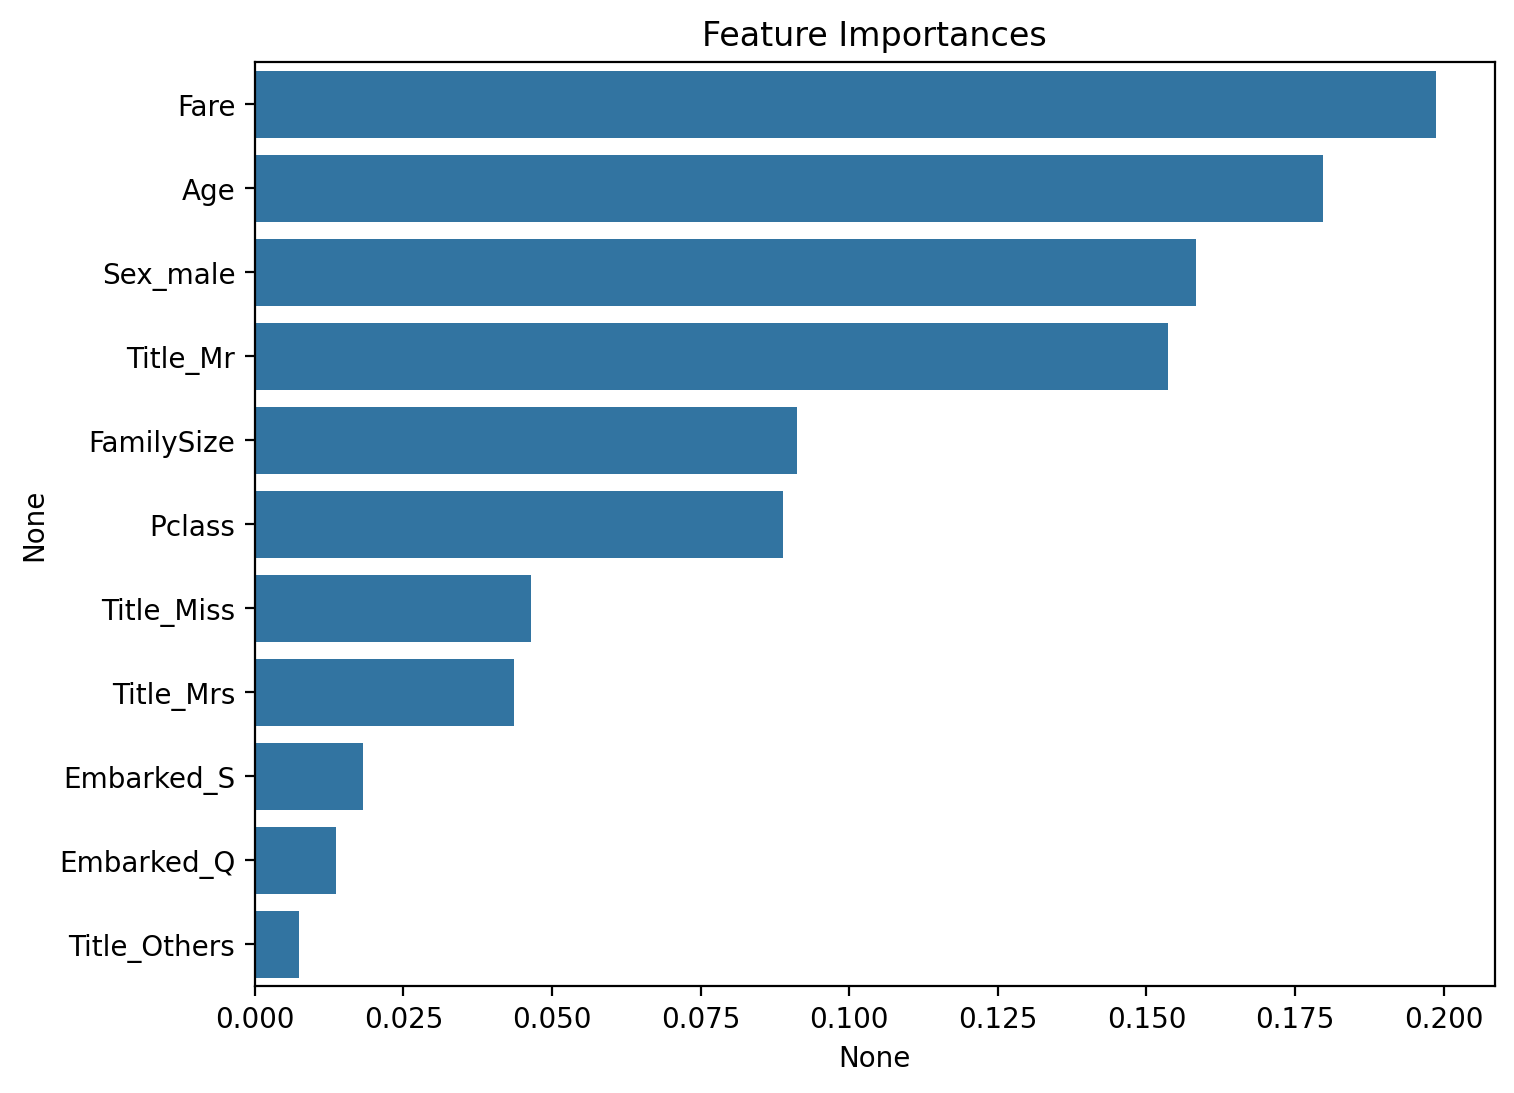

In [84]:
# 변수 중요도 계산

importances_values = pd.Series(ms_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# 변수 중요도 시각화

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=importances_values, y=importances_values.index)
plt.show()

- Fare, Age, Sex_male 순으로 변수 중요도가 높게 나옴
- 지불한 운임 요금이 중요한 것을 보니 그 때 탄 사람들의 신분이 생존여부에 큰 영향을 미쳤다고 판단.
- 나이와 Sex_male이 중요한 것을 보니, 여성과 어린 아이들을 구명보트에 태웠다는 도메인 지식이 얼추 맞는 것 같음.
- 이러한 변수 중요도를 보고 나중에 타이타닉호와 비슷한 사건이 일어났을 때, 어떤 해결방안이 있을지 생각해야함.

## 최종모델 - test 예측

In [85]:
#### 모델 선언

final_model = RandomForestClassifier(random_state=42, max_depth= 9,
                                 min_samples_split= 2,n_estimators= 200)

#### 모델 학습

final_model.fit(x_train, y_train)

#### test 데이터로 예측

test['Survived'] = 0
test['Survived'] = final_model.predict(x_test)

In [86]:
test

,Pclass,Age,Fare,FamilySize,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Sex_male,Embarked_Q,Embarked_S,Survived
0,0,34.500000,7.8292,0,False,True,False,False,True,True,False,0
1,0,47.000000,7.0000,1,False,False,True,False,False,False,True,0
2,1,62.000000,9.6875,0,False,True,False,False,True,True,False,0
3,0,27.000000,8.6625,0,False,True,False,False,True,False,True,0
4,0,22.000000,12.2875,2,False,False,True,False,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,32.000000,8.0500,0,False,True,False,False,True,False,True,0
414,2,39.000000,108.9000,0,False,False,True,False,False,False,False,1
415,0,38.500000,7.2500,0,False,True,False,False,True,False,True,0
416,0,32.000000,8.0500,0,False,True,False,False,True,False,True,0


In [87]:
test.to_csv('test_예측완료.csv', index = False)

### (+) k-fold 검증

In [88]:
from sklearn.model_selection import KFold

In [89]:
X_train = train.drop(['Survived'], axis =1)
y_train = train['Survived']

In [90]:
kfold = KFold(n_splits=5, shuffle=True, random_state=10)

In [91]:
model_k = RandomForestClassifier(random_state=42, max_depth= 9,
                                 min_samples_split= 2,n_estimators= 200)

In [92]:
score_f1 = []


for trn_idx, val_idx in kfold.split(X_train, y_train):
    
    X_trn, y_trn = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]
    X_val, y_val = X_train.iloc[val_idx, :], y_train.iloc[val_idx]
    
    model_k.fit(X_trn, y_trn)
    
    y_pred = model_k.predict(X_val)
    
    print('예측 완료')
    
    score_f1.append(f1_score(y_val, y_pred))

mean_score = sum(score_f1) / len(score_f1)
print(mean_score)

예측 완료
예측 완료
예측 완료
예측 완료
예측 완료
0.7550306404499535


In [93]:
result = []

kfold = KFold(n_splits=5, shuffle=True, random_state=10)

for trn_idx, val_idx in kfold.split(X_train, y_train):
    
    X_trn, y_trn = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]
    X_val, y_val = X_train.iloc[val_idx, :], y_train.iloc[val_idx]
    
    model_k.fit(X_trn, y_trn)
    
    y_pred = model_k.predict(x_test)
    
    result.append(model_k.predict(x_test))

In [94]:
# axis=0으로 최빈값 계산
from scipy.stats import mode

final_predictions = mode(result, axis=0).mode[0]

In [95]:
test['Survived'] = final_predictions

In [96]:
test.Survived.value_counts()

Survived
0    418
Name: count, dtype: int64

In [97]:
test.to_csv('test_예측완료_kf.csv', index = False)